In [3]:
import json
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
with open('conversations_with_lufthansa.json', 'r', encoding='utf-8') as f:
    convs = json.load(f)

# flatten each message into a single DataFrame
rows = []
for conv in convs:
    for msg in conv:
        rows.append({
            'root':      msg['conversation_root'],
            'idx':       msg['conversation_index'],
            'created':   msg['created_at'],
            'user_id':   msg['user']['id_str'],
            'neg':       msg['sentiment_scores']['neg'],
            'neu':       msg['sentiment_scores']['neu'],
            'pos':       msg['sentiment_scores']['pos'],
        })

df = pd.DataFrame(rows)

# parse timestamps
df['created'] = pd.to_datetime(
    df['created'],
    format='%a %b %d %H:%M:%S +0000 %Y', #formatting to datetime format
    utc=True
)

COMPANY_ID = '124476322'   #lufthansa

stats = []
for _, conv in df.groupby('root'): #grouping the tweets by root id
    conv = conv.sort_values('created')
    prev = None
    for _, row in conv.iterrows():
        if row['user_id'] == COMPANY_ID and prev is not None:
            rt = (row['created'] - prev['created']).total_seconds() / 60.0 #converting to minutes
            change = row['pos'] - prev['pos'] #change of sentiment calculation
            # Record the company response timestamp as 'response_created'
            stats.append({
                'response_time': rt,
                'sentiment_change': change,
                'response_created': row['created'],  # <<<<
            })
        prev = row

stats_df = pd.DataFrame(stats)


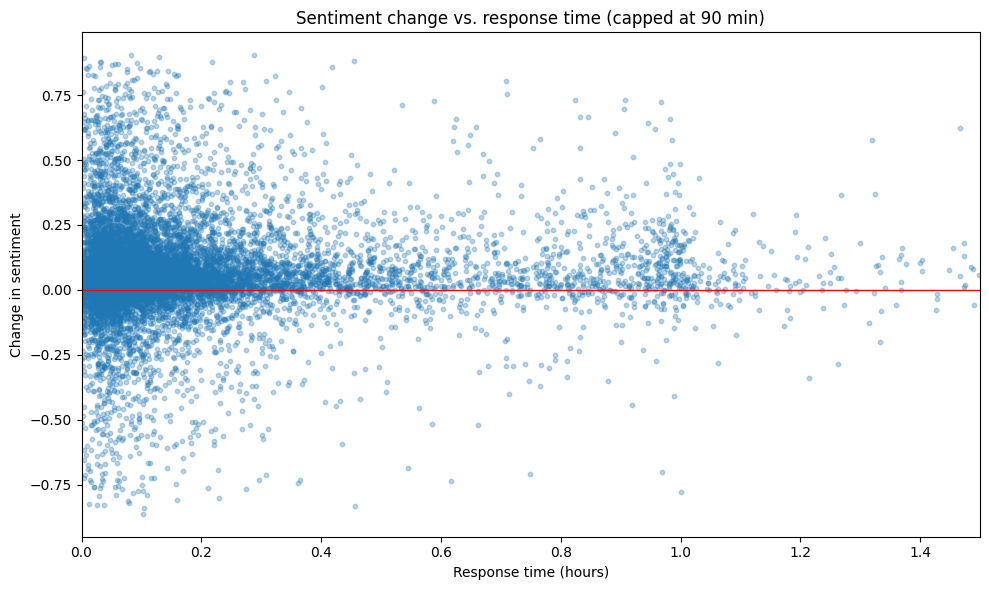

In [ ]:
max_min = 90 #maximum response time allowed
selected_month = 0  # 0 = all, 1 = Jan, ..., 12 = Dec

df = stats_df[stats_df['response_time'] <= max_min].copy() #creating a mask for dataframe
df['month'] = pd.to_datetime(df['response_created']).dt.month #converting again to datetime and extracting just the month from each

if selected_month != 0:
    df = df[df['month'] == selected_month] #filters for the selected month

df['response_hours'] = df['response_time'] / 60.0 #convert to hour

plt.figure(figsize=(10,6))
plt.scatter(df['response_hours'], df['sentiment_change'], alpha=0.3, s=10)
plt.axhline(0, color='red', linewidth=1)
plt.xlim(0, max_min / 60.0)
plt.xlabel('Response time (hours)')
plt.ylabel('Change in sentiment')
title = f'Sentiment change vs. response time (capped at {max_min} min)'
if selected_month != 0:
    title += f', Month={selected_month}'
plt.title(title)
plt.tight_layout()
plt.show()
